Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [3]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 2 - Data Preprocessing

## 2.1 Converting prices to returns

### How to do it

1. Import the libraries:

In [3]:
import pandas as pd 
import numpy as np
import yfinance as yf

2. Download the data and keep the adjusted close prices only:

In [4]:
df = yf.download("AAPL", 
                 start="2010-01-01", 
                 end="2020-12-31",
                 progress=False)

df = df.loc[:, ["Adj Close"]]

3. Convert adjusted close prices to simple and log returns:

In [5]:
df["simple_rtn"] = df["Adj Close"].pct_change()
df["log_rtn"] = np.log(df["Adj Close"]/df["Adj Close"].shift(1))

4. Inspect the output:

In [6]:
df.head()

,Adj Close,simple_rtn,log_rtn
Date,,,
2009-12-31,6.444379,NaN,NaN
2010-01-04,6.544686,0.015565,0.015445
2010-01-05,6.556003,0.001729,0.001728
2010-01-06,6.451722,-0.015906,-0.016034
2010-01-07,6.439794,-0.001849,-0.001851


## 2.2 Adjusting the returns for inflation

### How to do it

0. Recreating the steps from the previous recipe:

In [5]:
import yfinance as yf

df = yf.download("AAPL", 
                 start="2010-01-01", 
                 end="2020-12-31",
                 progress=False)

df = df.loc[:, ["Adj Close"]]

1. Import libraries and authenticate:

In [6]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Resample daily prices to monthly:

In [7]:
df = df.resample("M").last()
df

,Adj Close
Date,
2009-12-31,6.434927
2010-01-31,5.864813
2010-02-28,6.248349
2010-03-31,7.176042
2010-04-30,7.972735
...,...
2020-08-31,127.677979
2020-09-30,114.587616
2020-10-31,107.710991


3. Download inflation data from Nasdaq Data Link:

In [8]:
df_cpi = (
    nasdaqdatalink.get(dataset="RATEINF/CPI_USA", 
                       start_date="2009-12-01", 
                       end_date="2020-12-31")
    .rename(columns={"Value": "cpi"})
)

In [9]:
df_cpi

,cpi
Date,
2009-12-31,215.949
2010-01-31,216.687
2010-02-28,216.741
2010-03-31,217.631
2010-04-30,218.009
...,...
2020-08-31,259.918
2020-09-30,260.280
2020-10-31,260.388


4. Join inflation data to prices:

In [10]:
df = df.join(df_cpi, how="left")

5. Calculate simple returns and inflation rate:

In [11]:
df["simple_rtn"] = df["Adj Close"].pct_change()
df["inflation_rate"] = df["cpi"].pct_change()

6. Adjust the returns for inflation:

In [12]:
df["real_rtn"] = (
    (df["simple_rtn"] + 1) / (df["inflation_rate"] + 1) - 1
)
df.head()

,Adj Close,cpi,simple_rtn,inflation_rate,real_rtn
Date,,,,,
2009-12-31,6.434927,215.949,NaN,NaN,NaN
2010-01-31,5.864813,216.687,-0.088597,0.003417,-0.091701
2010-02-28,6.248349,216.741,0.065396,0.000249,0.065131
2010-03-31,7.176042,217.631,0.148470,0.004106,0.143773
2010-04-30,7.972735,218.009,0.111021,0.001737,0.109095


### There's more

1. Import the library:

In [13]:
import cpi

/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


In [14]:
# in the case of seeing the `StaleDataWarning: CPI data is out of date`
cpi.update()

2. Obtain the default CPI series:

In [15]:
cpi_series = cpi.series.get()
cpi_series

<Series: CUUR0000SA0: All items in U.S. city average, all urban consumers, not seasonally adjusted>

In [16]:
print(cpi_series)

CUUR0000SA0: All items in U.S. city average, all urban consumers, not seasonally adjusted


3. Convert the object into a `pandas` DataFrame:

In [17]:
df_cpi_2 = cpi_series.to_dataframe()

4. Filter the DataFrame and view the top 12 observations:

In [18]:
df_cpi_2.query("period_type == 'monthly' and year >= 2010") \
        .loc[:, ["date", "value"]] \
        .set_index("date") \
        .head(12)

,value
date,
2010-01-01,216.687
2010-02-01,216.741
2010-03-01,217.631
2010-04-01,218.009
2010-05-01,218.178
2010-06-01,217.965
2010-07-01,218.011
2010-08-01,218.312
2010-09-01,218.439


## 2.3 Changing the frequency of time series data

### How to do it

0. Obtain the log returns in case of starting in this recipe:

In [20]:
import pandas as pd 
import yfinance as yf
import numpy as np

# download data 
df = yf.download("AAPL", 
                 start="2000-01-01", 
                 end="2010-12-31", 
                 auto_adjust=False,
                 progress=False)

# keep only the adjusted close price
df = df.loc[:, ["Adj Close"]] \
       .rename(columns={"Adj Close": "adj_close"})

# calculate simple returns
df["log_rtn"] = np.log(df["adj_close"]/df["adj_close"].shift(1))

# remove redundant data
df = df.drop("adj_close", axis=1) \
       .dropna(axis=0)

df.head()

,log_rtn
Date,
2000-01-03,0.085034
2000-01-04,-0.088077
2000-01-05,0.014527
2000-01-06,-0.090514
2000-01-07,0.046281


1. Import the libraries:

In [21]:
import pandas as pd 
import numpy as np

2. Define the function for calculating the realized volatility:

In [22]:
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

3. Calculate monthly realized volatility:

In [25]:
df_rv = (
    df.groupby(pd.Grouper(freq="M"))
    .apply(realized_volatility)
    .rename(columns={"log_rtn": "rv"})
)

4. Annualize the values:

In [26]:
df_rv.rv = df_rv["rv"] * np.sqrt(12)

5. Plot the results:

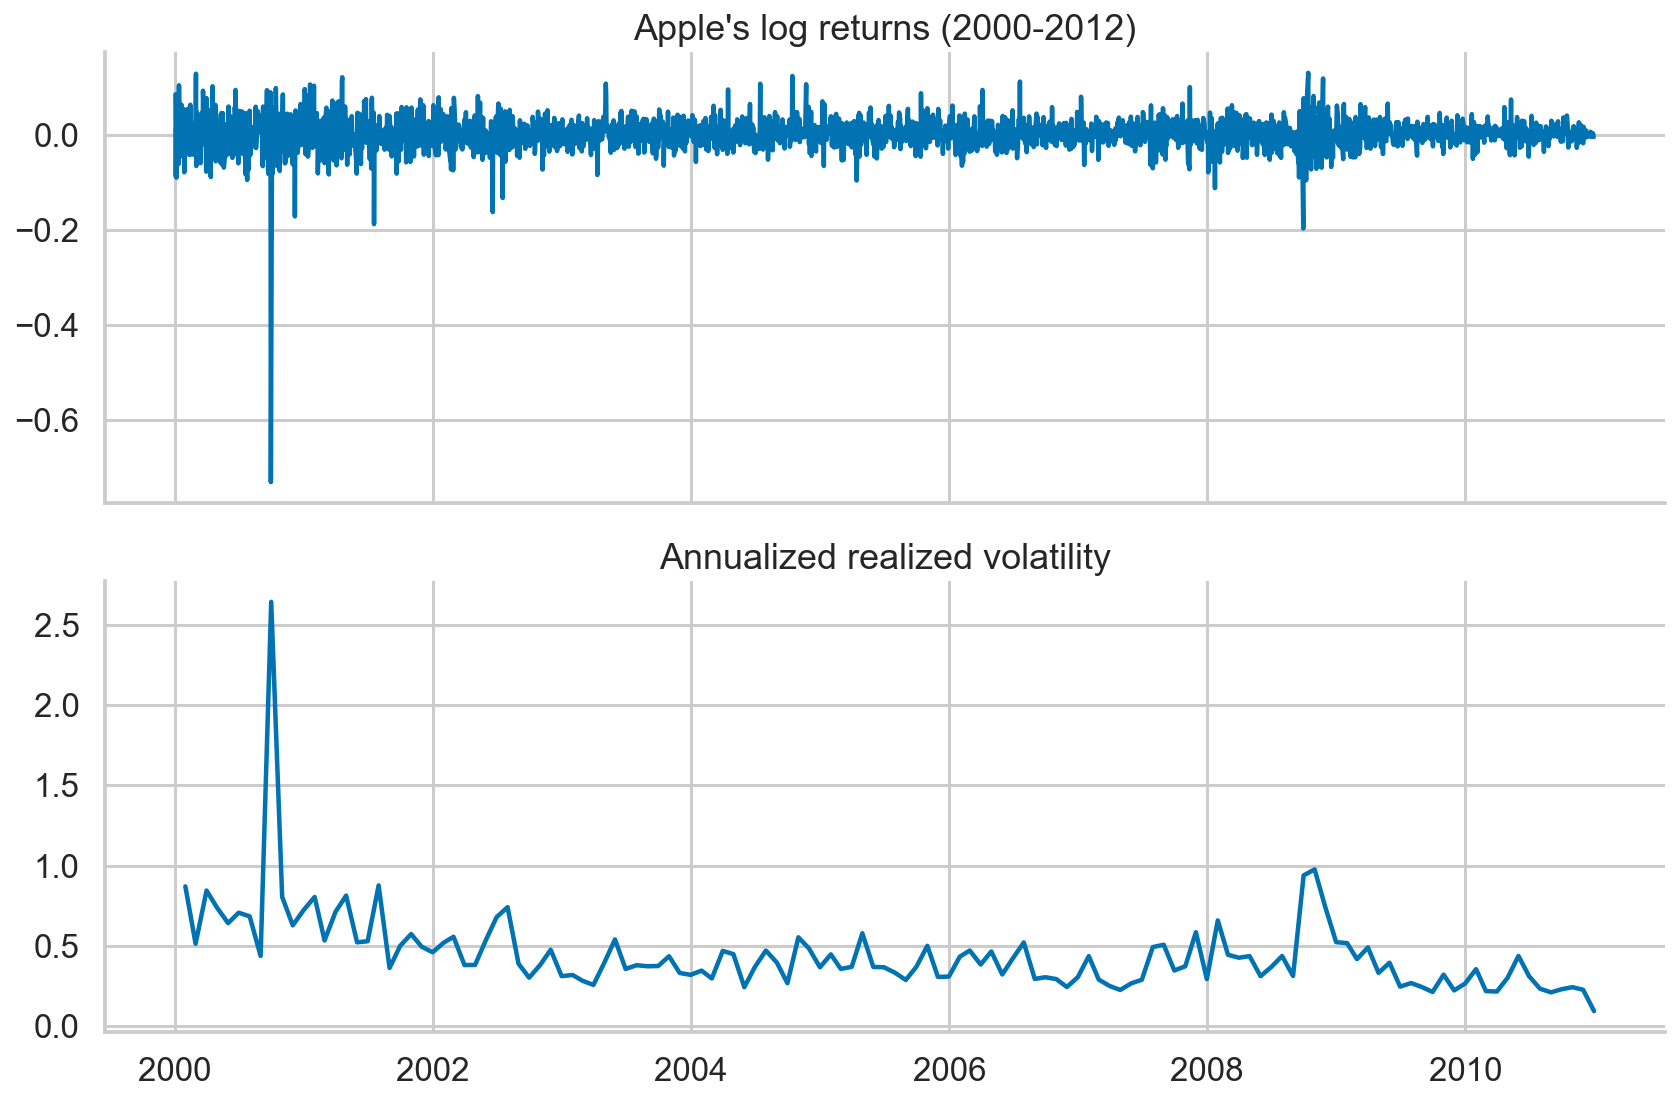

In [28]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df)
ax[0].set_title("Apple's log returns (2000-2012)")
ax[1].plot(df_rv)
ax[1].set_title("Annualized realized volatility")

sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_2_5', dpi=200)

## 2.4 Different ways of imputing missing data

### How to do it

1. Import the libraries:

In [29]:
import pandas as pd
import numpy as np
import nasdaqdatalink

2. Download the inflation data from Nasdaq Data Link:

In [30]:
nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE" 

df = (
    nasdaqdatalink.get(dataset="RATEINF/CPI_USA", 
                       start_date="2015-01-01", 
                       end_date="2020-12-31")
    .rename(columns={"Value": "cpi"})
)

3. Introduce 5 missing values at random:

In [31]:
np.random.seed(42)
rand_indices = np.random.choice(df.index, 5, replace=False)

df["cpi_missing"] = df.loc[:, "cpi"]
df.loc[rand_indices, "cpi_missing"] = np.nan
df.head()

,cpi,cpi_missing
Date,,
2015-01-31,233.707,NaN
2015-02-28,234.722,234.722
2015-03-31,236.119,236.119
2015-04-30,236.599,236.599
2015-05-31,237.805,NaN


4. Fill the missing values using different methods:

In [32]:
for method in ["bfill", "ffill"]:
    df[f"method_{method}"] = (
        df[["cpi_missing"]].fillna(method=method)
    )

5. Inspect the results by displaying the rows in which we created the missing values:

In [33]:
df.loc[rand_indices].sort_index()

,cpi,cpi_missing,method_bfill,method_ffill
Date,,,,
2015-01-31,233.707,NaN,234.722,NaN
2015-05-31,237.805,NaN,238.638,236.599
2016-07-31,240.647,NaN,240.849,241.038
2017-05-31,244.733,NaN,244.955,244.524
2020-03-31,258.115,NaN,256.389,258.678


6. Plot the results for years 2000-2001:

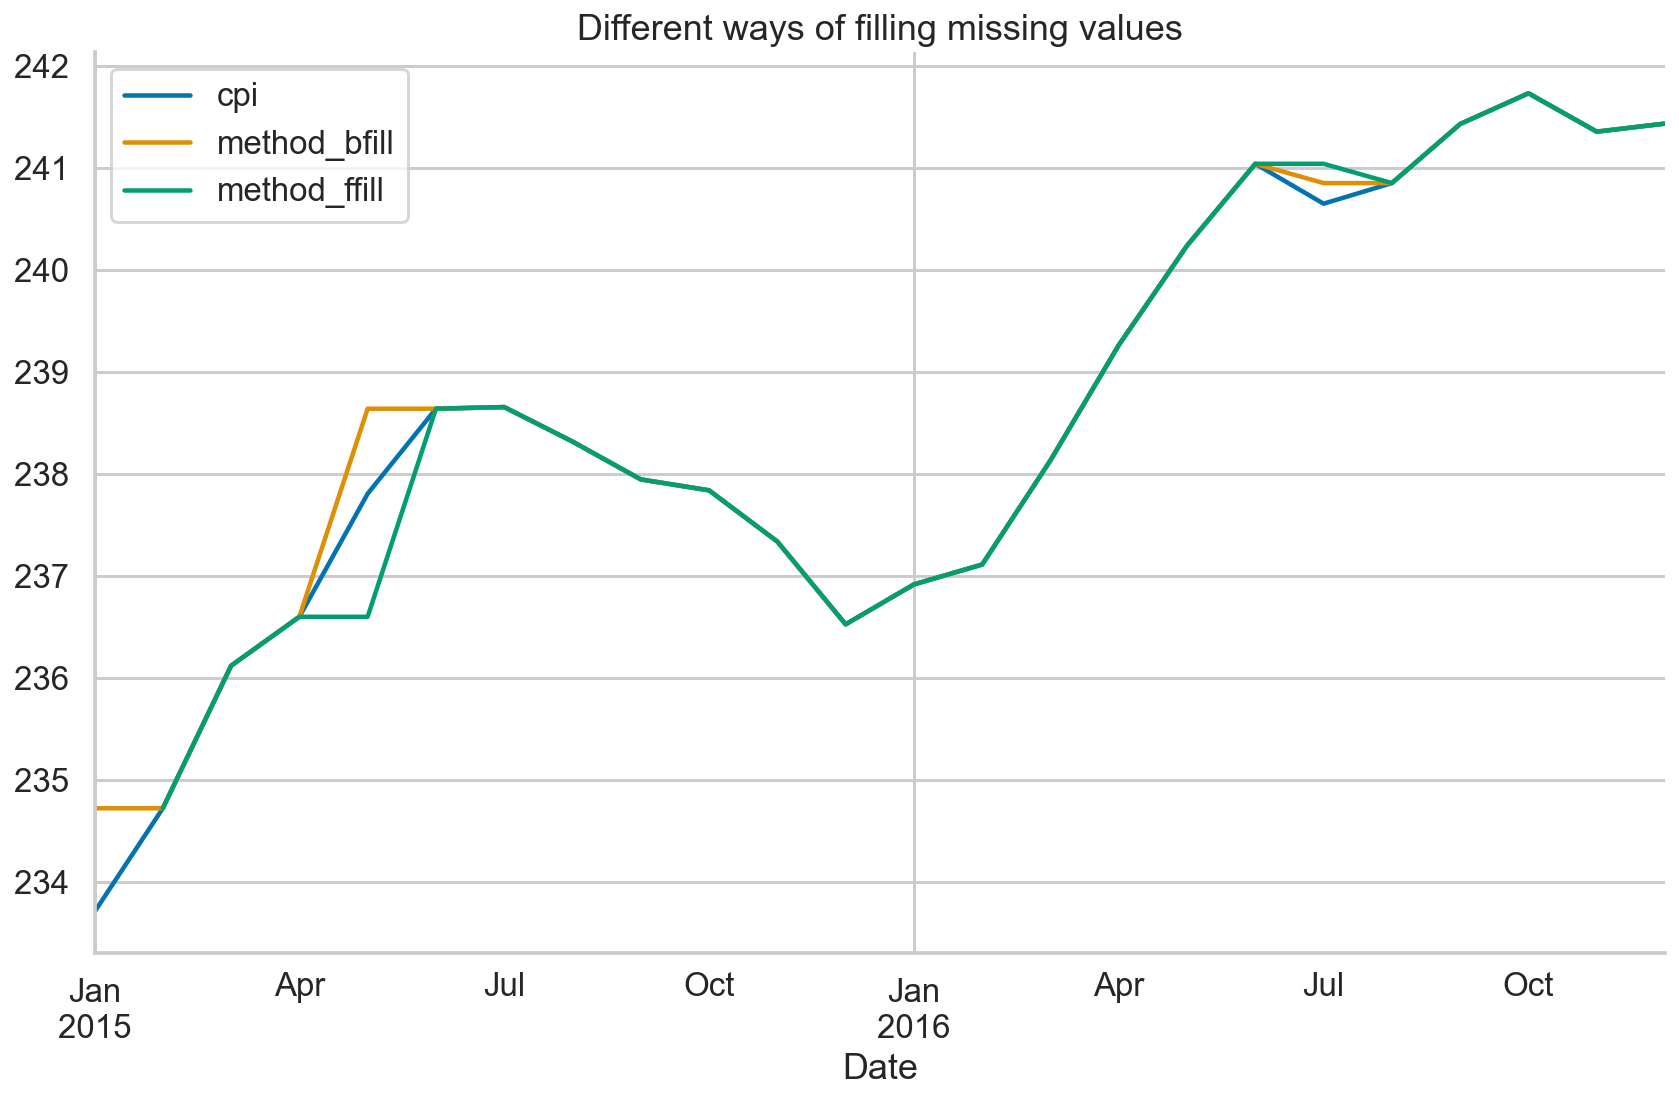

In [34]:
df.loc[:"2017-01-01"] \
  .drop(columns=["cpi_missing"]) \
  .plot(title="Different ways of filling missing values");

sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_2_8', dpi=200)

### There's more

1. Use linear interpolation to fill the missing values:

In [35]:
df["method_interpolate"] = df[["cpi_missing"]].interpolate()

2. Inspect the results:

In [36]:
df.loc[rand_indices].sort_index()

,cpi,cpi_missing,method_bfill,method_ffill,method_interpolate
Date,,,,,
2015-01-31,233.707,NaN,234.722,NaN,NaN
2015-05-31,237.805,NaN,238.638,236.599,237.6185
2016-07-31,240.647,NaN,240.849,241.038,240.9435
2017-05-31,244.733,NaN,244.955,244.524,244.7395
2020-03-31,258.115,NaN,256.389,258.678,257.5335


3. Plot the results:

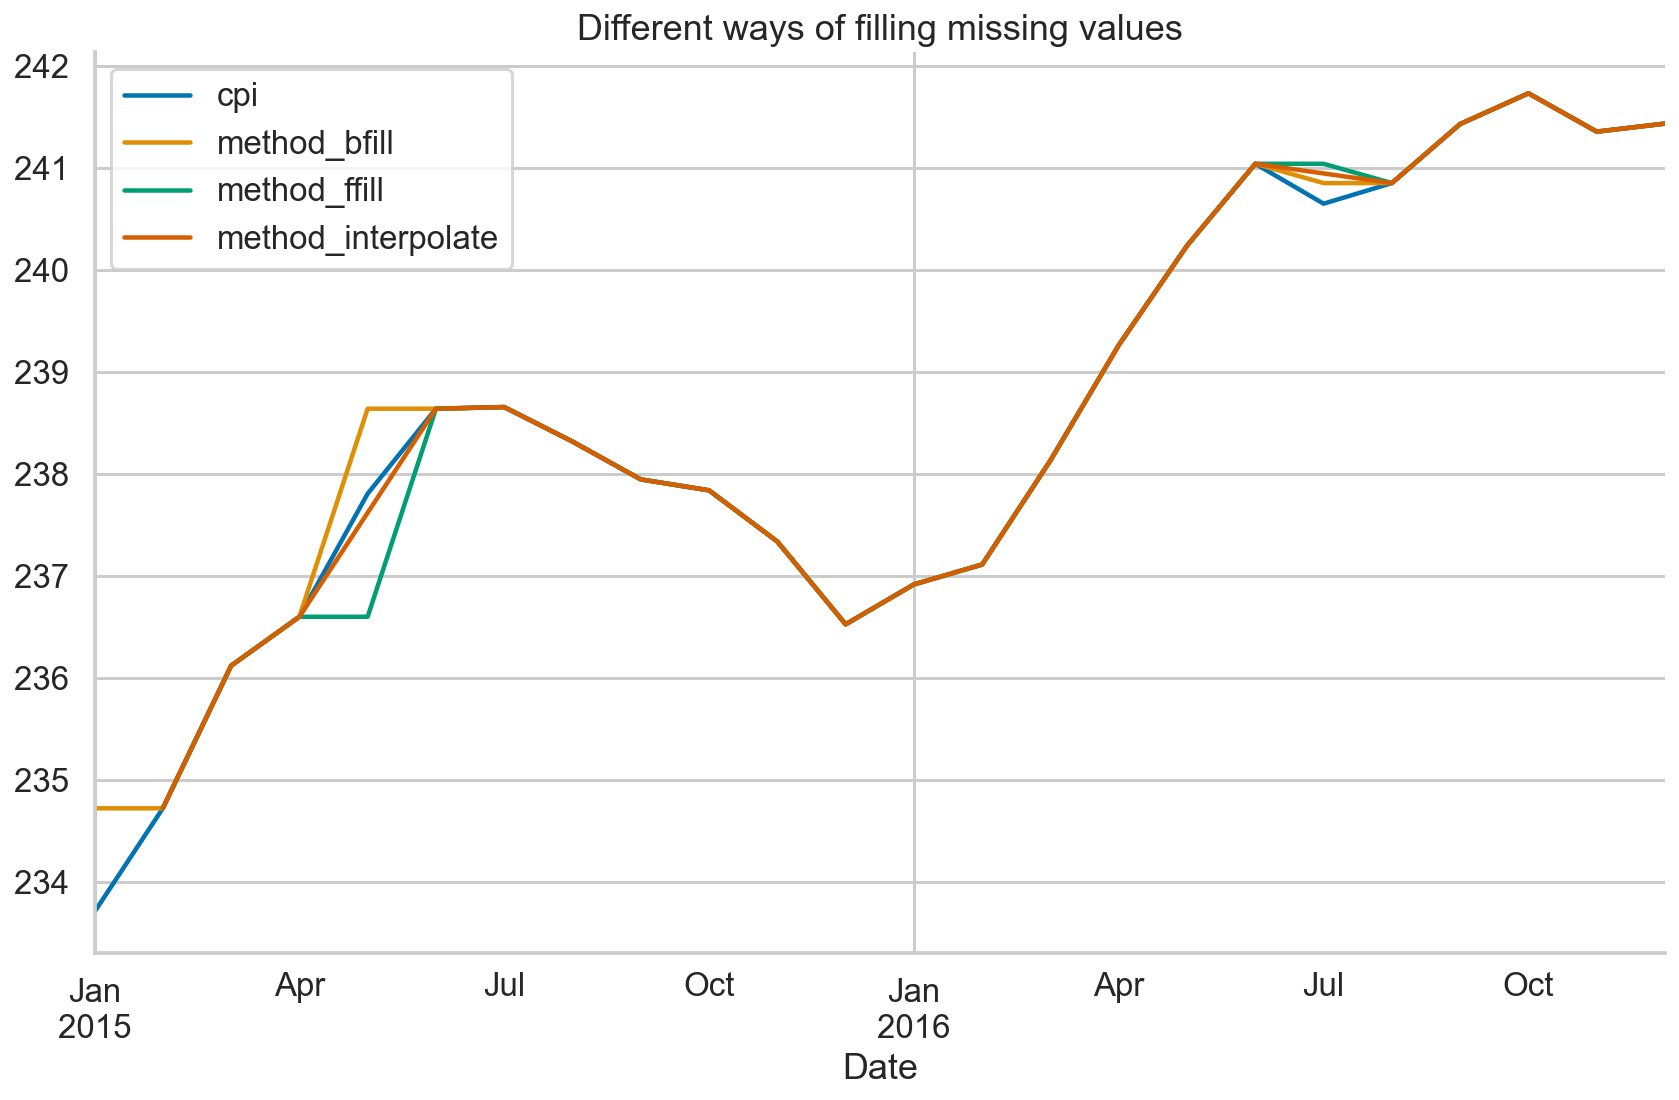

In [37]:
df.loc[:"2017-01-01"] \
  .drop(columns=["cpi_missing"]) \
  .plot(title="Different ways of filling missing values");

sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_2_10', dpi=200)

## 2.5 Converting currencies

### How to do it

1. Import the libraries:

In [38]:
import pandas as pd 
import yfinance as yf
from forex_python.converter import CurrencyRates


2. Download Apple's OHLC prices from January 2020:

In [39]:
df = yf.download("AAPL", 
                 start="2020-01-01", 
                 end="2020-01-31",
                 progress=False)
df = df.drop(columns=["Adj Close", "Volume"])

3. Instantiate the `CurrencyRates` object:

In [40]:
c = CurrencyRates()

4. Download the USD/EUR rate for each required date:

In [41]:
df["usd_eur"] = [c.get_rate("USD", "EUR", date) for date in df.index]

5. Convert the prices in USD to EUR:

In [43]:
for column in df.columns[:-1]:
    df[f"{column}_EUR"] = df[column] * df["usd_eur"]
df.head().round(3)

,Open,High,Low,Close,usd_eur,Open_EUR,High_EUR,Low_EUR,Close_EUR,usd_eur_EUR,Open_EUR_EUR,High_EUR_EUR,Low_EUR_EUR
Date,,,,,,,,,,,,,
2019-12-31,72.482,73.420,72.380,73.412,0.890,64.521,65.355,64.429,65.348,0.792,57.433,58.176,57.352
2020-01-02,74.060,75.150,73.798,75.088,0.893,66.166,67.140,65.932,67.084,0.798,59.114,59.984,58.905
2020-01-03,74.287,75.145,74.125,74.357,0.897,66.643,67.413,66.498,66.706,0.805,59.786,60.476,59.655
2020-01-06,73.448,74.990,73.188,74.950,0.893,65.613,66.991,65.381,66.956,0.798,58.615,59.846,58.407
2020-01-07,74.960,75.225,74.370,74.598,0.895,67.096,67.334,66.568,66.772,0.801,60.058,60.270,59.585


### There's more

1. Get the USD exchange rates to 31 available currencies:

In [44]:
usd_rates = c.get_rates("USD")
usd_rates

{'EUR': 0.8815232722143864,
 'JPY': 115.10930888575459,
 'BGN': 1.7240832157968968,
 'CZK': 21.573519040902678,
 'DKK': 6.557475317348377,
 'GBP': 0.7357457686882933,
 'HUF': 314.92418899858956,
 'PLN': 4.00925599435825,
 'RON': 4.360719322990127,
 'SEK': 9.313998589562763,
 'CHF': 0.9195169252468264,
 'ISK': 124.47108603667135,
 'NOK': 8.844763751763047,
 'HRK': 6.643335684062059,
 'RUB': 80.11204160789843,
 'TRY': 13.8285437235543,
 'AUD': 1.3744710860366711,
 'BRL': 5.007757404795486,
 'CAD': 1.2688645980253879,
 'CNY': 6.317789139633286,
 'HKD': 7.8040373765867415,
 'IDR': 14342.489421720733,
 'INR': 74.58876939351198,
 'KRW': 1190.259167842031,
 'MXN': 20.193846967559942,
 'MYR': 4.185472496473907,
 'NZD': 1.470292665726375,
 'PHP': 51.11071932299012,
 'SGD': 1.3445874471086037,
 'THB': 32.264633286318755,
 'ZAR': 15.030677009873058}

In [45]:
len(usd_rates)

31

2. Download the USD/EUR exchange rate from Yahoo Finance:

In [46]:
df = yf.download("USDEUR=X", 
                 start="2000-01-01", 
                 end="2010-12-31",
                 progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,0.83098,0.83724,0.83056,0.83577,0.83577,0
2003-12-02,0.83605,0.83710,0.82583,0.82720,0.82720,0
2003-12-03,0.82713,0.82802,0.82440,0.82488,0.82488,0
2003-12-04,0.82508,0.83029,0.82345,0.82775,0.82775,0
2003-12-05,0.82795,0.82878,0.82028,0.82055,0.82055,0


## 2.6 Different ways of aggregating trade data

### How to do it

1. Import the libraries:

In [47]:
from binance.spot import Spot as Client
import pandas as pd 
import numpy as np


2. Instantiate the Binance client and download the last 500 `BTCEUR` trades:

In [48]:
spot_client = Client(base_url="https://api3.binance.com")
r = spot_client.trades("BTCEUR")

3. Process the downloaded trades into a `pandas` DataFrame:

In [52]:
df = (
    pd.DataFrame(r)
    .drop(columns=["isBuyerMaker", "isBestMatch"])
)
df["time"] = pd.to_datetime(df["time"], unit="ms")

for column in ["price", "qty", "quoteQty"]:
    df[column] = pd.to_numeric(df[column])
df

,id,price,qty,quoteQty,time
0,77999355,33285.50,0.00288,95.862240,2022-02-23 19:41:15.896
1,77999356,33286.84,0.00336,111.843782,2022-02-23 19:41:15.896
2,77999357,33275.29,0.00813,270.528108,2022-02-23 19:41:15.941
3,77999358,33277.44,0.01001,333.107174,2022-02-23 19:41:17.896
4,77999359,33275.29,0.01001,333.085653,2022-02-23 19:41:17.900
...,...,...,...,...,...
495,77999850,33268.98,0.00067,22.290217,2022-02-23 19:50:56.806
496,77999851,33268.49,0.00249,82.838540,2022-02-23 19:50:56.806
497,77999852,33268.98,0.02126,707.298515,2022-02-23 19:50:58.903
498,77999853,33268.00,0.00596,198.277280,2022-02-23 19:50:58.903


4. Define a function aggregating the raw trades information:

In [50]:
def get_bars(df, add_time=False):
    """[summary]

    Args:
        df ([type]): [description]

    Returns:
        [type]: [description]
    """
    ohlc = df["price"].ohlc()
    vwap = (
        df.apply(lambda x: np.average(x["price"], weights=x["qty"]))
        .to_frame("vwap")
    )
    vol = df["qty"].sum().to_frame("vol")
    cnt = df["qty"].size().to_frame("cnt")
    
    if add_time:
        time = df["time"].last().to_frame("time")
        res = pd.concat([time, ohlc, vwap, vol, cnt], axis=1)
    else:
        res = pd.concat([ohlc, vwap, vol, cnt], axis=1)
    return res

5. Get time bars:

In [51]:
df_grouped_time = df.groupby(pd.Grouper(key="time", freq="1Min"))
time_bars = get_bars(df_grouped_time)
time_bars

,open,high,low,close,vwap,vol,cnt
time,,,,,,,
2022-02-23 19:41:00,33285.50,33286.84,33254.00,33269.47,33269.239073,0.71050,52
2022-02-23 19:42:00,33265.24,33265.63,33226.18,33231.76,33237.848521,2.26604,110
2022-02-23 19:43:00,33234.74,33250.30,33215.73,33240.09,33231.975184,0.70111,73
2022-02-23 19:44:00,33240.10,33240.10,33216.23,33231.33,33234.523449,0.81760,21
2022-02-23 19:45:00,33227.68,33286.04,33226.31,33279.94,33245.756842,3.39557,89
2022-02-23 19:46:00,33270.23,33305.45,33266.54,33279.62,33284.459090,0.46893,31
2022-02-23 19:47:00,33283.24,33328.46,33273.90,33322.05,33295.109170,0.30348,32
2022-02-23 19:48:00,33308.50,33333.98,33297.37,33315.46,33315.803656,0.58047,37
2022-02-23 19:49:00,33310.42,33322.00,33281.73,33294.93,33309.609233,0.22579,21


6. Get tick bars:

In [53]:
bar_size = 50 
df["tick_group"] = (
    pd.Series(list(range(len(df))))
    .div(bar_size)
    .apply(np.floor)
    .astype(int)
    .values
)
df_grouped_ticks = df.groupby("tick_group")
tick_bars = get_bars(df_grouped_ticks, add_time=True)
tick_bars

,time,open,high,low,close,vwap,vol,cnt
tick_group,,,,,,,,
0,2022-02-23 19:41:57.784,33285.50,33286.84,33254.00,33270.89,33269.220356,0.65723,50
1,2022-02-23 19:42:29.168,33269.47,33269.47,33243.50,33243.50,33249.679200,0.75967,50
2,2022-02-23 19:42:43.886,33241.86,33244.71,33226.18,33230.04,33233.334328,1.45604,50
3,2022-02-23 19:43:37.837,33234.89,33244.70,33215.73,33222.93,33228.599024,0.31810,50
4,2022-02-23 19:44:28.440,33222.72,33250.30,33216.23,33216.98,33234.604510,1.26310,50
5,2022-02-23 19:45:15.153,33226.01,33258.29,33221.43,33233.13,33236.663489,1.87995,50
6,2022-02-23 19:46:02.625,33233.13,33286.04,33233.13,33284.14,33256.233756,1.56017,50
7,2022-02-23 19:47:47.964,33284.89,33305.45,33266.54,33293.35,33284.115017,0.63715,50
8,2022-02-23 19:49:05.929,33294.13,33333.98,33294.13,33314.63,33314.426886,0.78777,50


7. Get volume bars:

In [54]:
bar_size = 1 
df["cum_qty"] = df["qty"].cumsum()
df["vol_group"] = (
    df["cum_qty"]
    .div(bar_size)
    .apply(np.floor)
    .astype(int)
    .values
)
df_grouped_ticks = df.groupby("vol_group")
volume_bars = get_bars(df_grouped_ticks, add_time=True)
volume_bars

,time,open,high,low,close,vwap,vol,cnt
vol_group,,,,,,,,
0,2022-02-23 19:42:19.499,33285.50,33286.84,33246.90,33250.00,33264.436711,0.99446,85
1,2022-02-23 19:42:31.215,33246.91,33253.07,33226.18,33226.87,33240.193454,0.86169,46
2,2022-02-23 19:43:04.416,33232.23,33244.71,33230.04,33239.77,33232.363594,1.12313,33
3,2022-02-23 19:44:01.139,33240.00,33250.30,33215.73,33240.10,33232.135781,0.71425,72
4,2022-02-23 19:45:12.130,33240.10,33258.29,33216.23,33241.21,33238.411739,1.25593,44
5,2022-02-23 19:45:15.146,33241.21,33241.21,33232.03,33233.13,33234.773416,0.83403,15
6,2022-02-23 19:45:21.810,33233.13,33253.41,33233.13,33248.69,33236.027748,1.21260,20
7,2022-02-23 19:46:23.762,33248.69,33286.04,33242.90,33281.10,33270.171474,0.99072,45
8,2022-02-23 19:48:32.173,33280.33,33333.98,33273.90,33301.66,33300.233202,0.98864,69


8. Get dollar bars:

In [55]:
bar_size = 50000 
df["cum_value"] = df["quoteQty"].cumsum()
df["value_group"] = (
    df["cum_value"]
    .div(bar_size)
    .apply(np.floor)
    .astype(int)
    .values
)
df_grouped_ticks = df.groupby("value_group")
dollar_bars = get_bars(df_grouped_ticks, add_time=True)
dollar_bars

,time,open,high,low,close,vwap,vol,cnt
value_group,,,,,,,,
0,2022-02-23 19:42:29.230,33285.50,33286.84,33239.96,33239.96,33258.572184,1.42997,103
1,2022-02-23 19:43:17.962,33239.96,33244.71,33226.18,33231.41,33233.221296,1.57424,66
2,2022-02-23 19:44:58.211,33231.40,33250.30,33215.73,33231.33,33233.232079,1.49104,87
3,2022-02-23 19:45:15.146,33227.68,33258.29,33226.31,33233.13,33238.544792,1.28824,39
4,2022-02-23 19:45:59.597,33233.13,33286.04,33233.13,33280.92,33243.191526,1.70740,43
5,2022-02-23 19:48:32.173,33279.94,33333.98,33266.54,33301.66,33293.331944,1.48456,91
6,2022-02-23 19:50:59.291,33301.65,33322.00,33268.00,33268.52,33292.741055,1.22762,71
